In [96]:
import pyvista as pv
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path


## Settings

In [97]:
# Input
file_glob = "VTK/*/internal.vtu"
file_paths = sorted(glob.glob(file_glob))
if len(file_paths) == 0:
    raise FileNotFoundError(f"No files found. Check your glob: {file_glob}")

# POD settings
energy_threshold = 0.99       # cumulative energy threshold for r
export_modes = True
export_reconstructions = True

# Output folders
out_root = Path("pod")
out_plots = out_root / "plots"
out_modes = out_root / "modes"
out_recon = out_root / "reconstructed"
out_data  = out_root / "data"

for p in [out_root, out_plots, out_modes, out_recon, out_data]:
    p.mkdir(parents=True, exist_ok=True)

print("Found snapshots:", len(file_paths))
print("Output root:", out_root.resolve())


Found snapshots: 401
Output root: /home/alexandrahutter/MA/flow_around_cylinder/of_cylinder2D_binary/pod


## 1) Load reference mesh, compute weights once

In [98]:
ref_mesh_raw = pv.read(file_paths[0])

# Compute cell sizes (VTK may provide Volume or Area depending on 2D/3D dataset type)
ref_mesh = ref_mesh_raw.compute_cell_sizes()
cell_keys = list(ref_mesh.cell_data.keys())

if "Volume" in cell_keys:
    cell_measure_name = "Volume"
elif "Area" in cell_keys:
    cell_measure_name = "Area"
else:
    raise KeyError(f"Neither 'Volume' nor 'Area' found in cell_data. Available: {cell_keys}")

# Lumped-style weights: cell measure -> point measure
ref_mesh = ref_mesh.cell_data_to_point_data()
if cell_measure_name not in ref_mesh.point_data:
    raise KeyError(f"Expected '{cell_measure_name}' in point_data. Available: {list(ref_mesh.point_data.keys())}")

weights = np.asarray(ref_mesh.point_data[cell_measure_name]).astype(float)
if np.any(weights <= 0):
    raise ValueError("Non-positive weights found. Check mesh.compute_cell_sizes output.")

# Velocity checks
if "U" not in ref_mesh.point_data:
    raise KeyError("Velocity field 'U' not found in point_data of reference mesh.")

U0 = np.asarray(ref_mesh.point_data["U"])
num_points = ref_mesh.n_points
num_components = U0.shape[1] if U0.ndim == 2 else 1

if num_components != 3:
    raise ValueError(f"Expected velocity with 3 components. Got: {U0.shape}")

# Expand sqrt weights to match flattened velocity vector (3*Np)
sqrt_weights = np.sqrt(weights)                    # (Np,)
sqrt_weights_expanded = np.repeat(sqrt_weights, 3) # (3*Np,)

print("\n--- Mesh & weights summary ---")
print("num_points:", num_points)
print(f"{cell_measure_name} weights: min/mean/max =", weights.min(), weights.mean(), weights.max())
print("domain measure approx sum(weights) =", weights.sum())
print("U0 shape:", U0.shape)



--- Mesh & weights summary ---
num_points: 28050
Volume weights: min/mean/max = 1.0488281091450841e-07 6.555401946867419e-07 1.2117798368112544e-06
domain measure approx sum(weights) = 0.018387902460963113
U0 shape: (28050, 3)


## 2) Load snapshots with mesh consistency checks

We collect velocity snapshots $\mathbf{u}(t_k) \in \mathbb{R}^{3N_p}$ at discrete times $t_k$ and build the snapshot matrix

$$
\mathbf{X} =
\begin{bmatrix}
| & | &        & | \\
\mathbf{u}(t_1) & \mathbf{u}(t_2) & \cdots & \mathbf{u}(t_{N_t}) \\
| & | &        & |
\end{bmatrix}
\in \mathbb{R}^{3N_p \times N_t}.
$$

In [99]:
snapshots = []
ref_points = np.asarray(ref_mesh.points)

for fp in file_paths:
    m = pv.read(fp)

    # Consistency checks: same points and ordering
    if m.n_points != num_points:
        raise ValueError(f"Point count mismatch in {fp}: {m.n_points} vs {num_points}")

    pts = np.asarray(m.points)
    if not np.allclose(pts, ref_points, rtol=0, atol=1e-12):
        raise ValueError(
            f"Point coordinates mismatch in {fp}. "
            "Mesh/point ordering must be identical across time for snapshot POD."
        )

    if "U" not in m.point_data:
        raise KeyError(f"Velocity field 'U' missing in {fp}")

    U = np.asarray(m.point_data["U"])      # (Np,3)
    snapshots.append(U.reshape(-1))        # (3*Np,)

X = np.column_stack(snapshots)             # (3*Np, Nt)
Nt = X.shape[1]

print("\n--- Snapshot matrix summary ---")
print("Nt (snapshots):", Nt)
print("X shape:", X.shape, " = (3*Np, Nt) =", (3*num_points, Nt))



--- Snapshot matrix summary ---
Nt (snapshots): 401
X shape: (84150, 401)  = (3*Np, Nt) = (84150, 401)


## 3) Mean subtraction (physical space), then apply weights, then SVD

## POD (weighted, fluctuation form)

We form the snapshot matrix  
$$
\mathbf{X} = [\mathbf{u}(t_1)\;\mathbf{u}(t_2)\;\dots\;\mathbf{u}(t_{N_t})] \in \mathbb{R}^{3N_p \times N_t}.
$$

### Mean subtraction (fluctuation POD)
$$
\bar{\mathbf{u}}=\frac{1}{N_t}\sum_{k=1}^{N_t}\mathbf{u}(t_k), \qquad 
\mathbf{X}_c=\mathbf{X}-\bar{\mathbf{u}}\mathbf{1}^T.
$$

### Weighted inner product (volume/area)
To approximate $\int_\Omega \mathbf{u}\cdot\mathbf{v}\,d\Omega$, we use diagonal weights $w_i$ at points and build an expanded weight matrix for 3 components:
$$
\mathbf{W}_v=\mathrm{diag}(w_1,w_1,w_1,\dots,w_{N_p},w_{N_p},w_{N_p}).
$$

We weight snapshots via
$$
\mathbf{X}_{cw}=\mathbf{W}_v^{1/2}\mathbf{X}_c.
$$



### SVD
$$
\mathbf{X}_{cw}=\mathbf{U}_w\mathbf{\Sigma}\mathbf{V}^T.
$$


In [110]:
# Mean subtraction (physical space)
X_mean = np.mean(X, axis=1, keepdims=True)
Xc = X - X_mean

# Weighting
Xcw = Xc * sqrt_weights_expanded[:, None]

# SVD
U_w, S_w, Vt_w = np.linalg.svd(Xcw, full_matrices=False)

print("\n--- SVD summary ---")
print("num_points:", num_points)
print("U_w shape:", U_w.shape)
print("S_w shape:", S_w.shape)
print("Vt_w shape:", Vt_w.shape)
print("mean(|X_mean|):", float(np.mean(np.abs(X_mean))))
print("First 10 singular values:", S_w[:10])



--- SVD summary ---
num_points: 28050
U_w shape: (84150, 401)
S_w shape: (401,)
Vt_w shape: (401, 401)
mean(|X_mean|): 0.3555361032485962
First 10 singular values: [0.46467421 0.45839022 0.23003885 0.16179322 0.12051785 0.0817897
 0.08077511 0.0774312  0.07553957 0.06179285]


## 4) Modal energy and truncation criterion

The energy fraction of mode $i$ is computed from singular values as

$$
E_i = \frac{\sigma_i^2}{\sum_{j=1}^{N_t}\sigma_j^2}.
$$

The cumulative captured energy up to mode $r$ is

$$
E_\text{cum}(r) = \sum_{i=1}^{r} E_i.
$$

A common truncation criterion is to choose the smallest $r$ such that

$$
E_\text{cum}(r) \ge \eta,
$$

where $\eta$ is a user-defined threshold (e.g., $0.99$).
- The **energy plot** shows how dominant the first modes are.
- The **log singular value decay** indicates how quickly information content drops.
- The **cumulative energy plot** shows how many modes are needed to reach the chosen threshold.



Energy fraction:
$$
E_i=\frac{\sigma_i^2}{\sum_j \sigma_j^2},\qquad E_{\mathrm{cum}}(r)=\sum_{i=1}^r E_i.
$$

### Physical POD modes and reconstruction
Physical-space modes:
$$
\boldsymbol{\phi}_i=\mathbf{W}_v^{-1/2}\mathbf{u}_{w,i}.
$$

Rank-$r$ reconstruction:
$$
\widehat{\mathbf{X}}^{(r)}=\mathbf{W}_v^{-1/2}\left(\mathbf{U}_{w,r}\mathbf{\Sigma}_r\mathbf{V}_r^T\right)+\bar{\mathbf{u}}\mathbf{1}^T.
$$


## 4) Energy & rank selection

A rank-$r$ approximation in weighted space is
$$
\widehat{\mathbf{X}}_{cw}^{(r)} = \mathbf{U}_{w,r}\,\mathbf{\Sigma}_r\,\mathbf{V}_r^T.
$$

Transform back to physical space and add the mean:
$$
\widehat{\mathbf{X}}^{(r)} = \mathbf{W}_v^{-1/2}\,\widehat{\mathbf{X}}_{cw}^{(r)} + \bar{\mathbf{u}}\,\mathbf{1}^T.
$$

The reconstruction at time $t_k$ is then obtained from the $k$-th column.

In [105]:
energy = (S_w**2) / np.sum(S_w**2)
cumulative_energy = np.cumsum(energy)
cutoff_index = np.argmax(cumulative_energy >= energy_threshold)
r = int(cutoff_index + 1)

print("\n--- Truncation summary ---")
print("energy_threshold:", energy_threshold)
print("r (modes):", r)
print("captured energy:", float(cumulative_energy[r-1]))
print("mode-1 energy:", float(energy[0]))

# Save summary text
summary_path = out_data / "summary.txt"
with open(summary_path, "w") as f:
    f.write(f"Nt: {Nt}\n")
    f.write(f"num_points: {num_points}\n")
    f.write(f"DOF: {3*num_points}\n")
    f.write(f"weight_measure: {cell_measure_name}\n")
    f.write(f"sum(weights): {weights.sum()}\n")
    f.write(f"energy_threshold: {energy_threshold}\n")
    f.write(f"r: {r}\n")
    f.write(f"captured_energy: {cumulative_energy[r-1]}\n")
    f.write("first10_singular_values: " + " ".join(map(str, S_w[:10])) + "\n")

print("Saved:", summary_path)


--- Truncation summary ---
energy_threshold: 0.99
r (modes): 16
captured energy: 0.9916810471649865
mode-1 energy: 0.3823200744119617
Saved: pod/data/summary.txt


## What the plots tell you

- **Energy per mode**: if the first few modes contain most energy, the flow is strongly low-dimensional (good for ROM).
- **Log singular values**: fast decay suggests high compressibility; a long flat tail suggests many active scales.
- **Cumulative energy**: directly shows how many modes are needed to meet the chosen energy threshold.


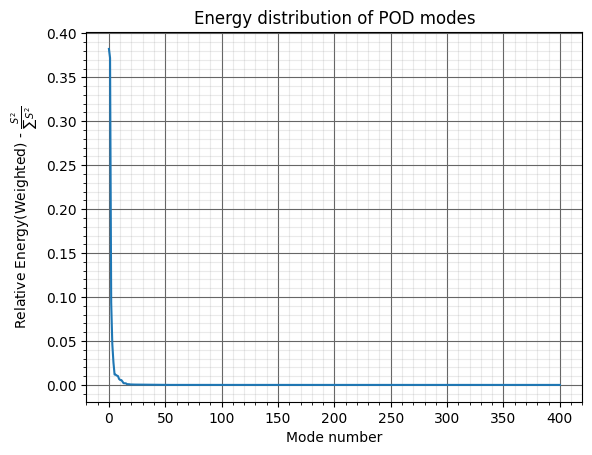

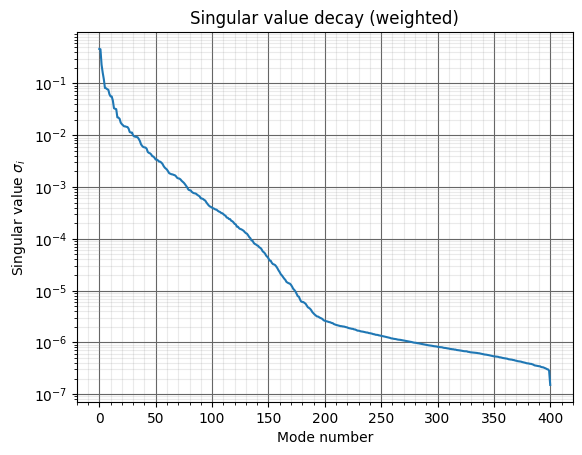

In [116]:
# Plot cumulative energy distribution
plt.plot(energy)
plt.xlabel("Mode number")
plt.ylabel(r"Relative Energy(Weighted) - $\frac{S^2}{\sum S^2}$")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title("Energy distribution of POD modes")
plt.savefig(out_plots / "energy_per_mode.png", dpi=200)
plt.show()

# Plot eigen value decay - log scale
plt.yscale("log")
plt.plot(S_w)
plt.xlabel("Mode number")
plt.ylabel(r"Singular value $\sigma_i$")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title("Singular value decay (weighted)")
plt.savefig(out_plots / "singular_values_log.png", dpi=200)
plt.show()


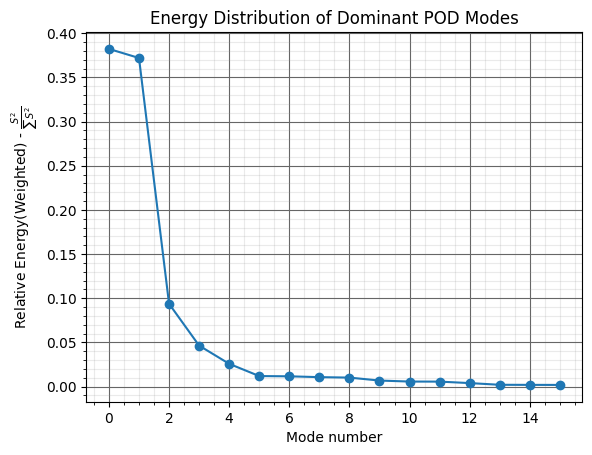

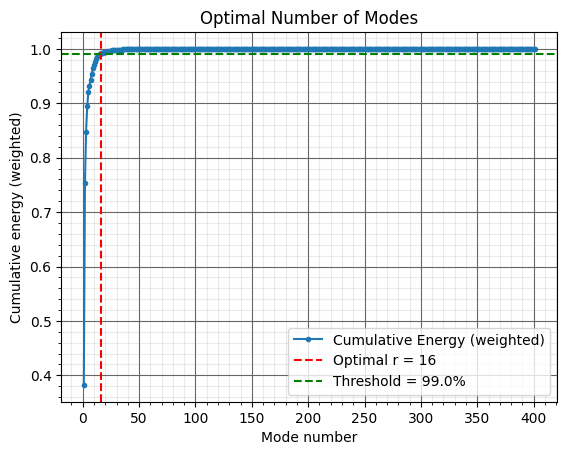

In [120]:
# Plot the energy distribution for modes up to the cutoff point
plt.plot(energy[:cutoff_index + 1], marker='o', linestyle='-')
plt.xlabel("Mode number")
plt.ylabel(r"Relative Energy(Weighted) - $\frac{S^2}{\sum S^2}$")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title("Energy Distribution of Dominant POD Modes")
plt.savefig(out_plots / "energy_opt_modes.png", dpi=200)
plt.show()

# Plot cumulative energy incl. threshold
plt.plot(np.arange(1, len(cumulative_energy) + 1), cumulative_energy, label='Cumulative Energy (weighted)',marker='.')
plt.axvline(r, color='r', linestyle='--', label=f'Optimal r = {r}')
plt.axhline(energy_threshold, color='g', linestyle='--', label=f'Threshold = {energy_threshold*100}%')
plt.xlabel("Mode number")
plt.ylabel("Cumulative energy (weighted)")
plt.title("Optimal Number of Modes")
plt.legend()
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.savefig(out_plots / "cumulative_energy.png", dpi=200)
plt.show()


## Orthonormality check

In [ ]:
G = U_w[:, :r].T @ U_w[:, :r]
orth_err = np.linalg.norm(G - np.eye(r))
print("Weighted-space orthonormality ||U^T U - I||_F =", orth_err)


## 5) Export POD modes (physical space) to VTU
IMPORTANT: modes from weighted SVD are in weighted coordinates.
Convert to physical modes by dividing by sqrt(W).

In [111]:
if export_modes:
    mode_mesh = ref_mesh.copy(deep=True)

    for i in range(r):
        # weighted mode
        phi_w = U_w[:, i]                         # (3*Np,)
        # physical mode
        phi = phi_w / sqrt_weights_expanded       # (3*Np,)
        mode_mesh.point_data[f"POD_mode_{i+1:03d}"] = phi.reshape(num_points, 3)

    out_file = out_modes / "POD_modes_all.vtu"
    mode_mesh.save(str(out_file))
    print("Saved modes:", out_file)


Saved modes: pod/modes/POD_modes_all.vtu


## 6) Reconstruct snapshots (physical space)
$Xcw_{hat} = U_r \sigma_r V_r^T$

$Xc_{hat}  = W^{-1/2} Xcw_{hat}$

$X_{hat}   = Xc_{hat} + mean$

In [112]:
reconstructed_fields = []

Ur = U_w[:, :r]      # (3*Np, r)
Sr = S_w[:r]         # (r,)
Vtr = Vt_w[:r, :]    # (r, Nt)

for t_idx, fp in enumerate(file_paths):
    # rank-r reconstruction in weighted space (centered)
    xcw_hat = (Ur * Sr) @ Vtr[:, t_idx]            # (3*Np,)

    # back to physical centered
    xc_hat = xcw_hat / sqrt_weights_expanded       # (3*Np,)

    # add mean
    x_hat = xc_hat + X_mean[:, 0]                  # (3*Np,)

    reconstructed = x_hat.reshape(num_points, 3)
    reconstructed_fields.append(reconstructed)

    if export_reconstructions:
        m = pv.read(fp)
        m.point_data["Reconstructed_U"] = reconstructed
        out_file = out_recon / f"Reconstructed_field_t{t_idx:04d}.vtu"
        m.save(str(out_file))

print("Saved reconstructions to:", out_recon)


Saved reconstructions to: pod/reconstructed


## 7) Reconstruction error metrics

We evaluate reconstruction quality using:

### Unweighted relative $L^2$ error
$$
\epsilon_\text{unw}(t_k) = 
\frac{\|\mathbf{u}(t_k) - \widehat{\mathbf{u}}^{(r)}(t_k)\|_2}{\|\mathbf{u}(t_k)\|_2}.
$$
This measures error in a purely algebraic sense (all DOFs treated equally).

### Weighted relative error (consistent with POD inner product)
$$
\epsilon_{W}(t_k) =
\frac{\sqrt{(\mathbf{e}^T \mathbf{W}_v \mathbf{e})}}{\sqrt{(\mathbf{u}^T \mathbf{W}_v \mathbf{u})}},
\quad \mathbf{e}=\mathbf{u}-\widehat{\mathbf{u}}^{(r)}.
$$
This approximates the error in an energy/volume-integrated sense and is consistent with the weighted POD construction.

The time evolution of $\epsilon(t_k)$ indicates whether reconstruction accuracy is stable across the transient.


## 7) Error metrics (unweighted + weighted)


--- Reconstruction error summary ---
Unweighted error:  min/mean/max = 0.01030769316593309 0.017771596302728936 0.0909972236585802
Weighted error:    min/mean/max = 0.009462749209018226 0.0181266307931199 0.06832784488092275
Worst weighted timestep index: 290


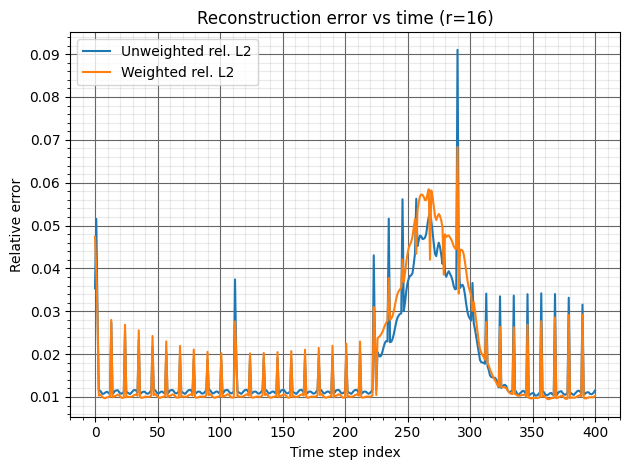

Saved plot: pod/plots/reconstruction_error_vs_time.png


In [121]:
relative_errors_unweighted = []
relative_errors_weighted = []

relative_errors_unweighted = []
relative_errors_weighted = []

w_expanded = sqrt_weights_expanded**2  # (3*Np,)

for t_idx, fp in enumerate(file_paths):
    m = pv.read(fp)
    u = np.asarray(m.point_data["U"]).reshape(-1)
    uhat = reconstructed_fields[t_idx].reshape(-1)
    e = u - uhat

    # unweighted
    err_unw = np.linalg.norm(e) / np.linalg.norm(u)
    relative_errors_unweighted.append(err_unw)

    # weighted
    num = np.sqrt(np.sum(w_expanded * e**2))
    den = np.sqrt(np.sum(w_expanded * u**2))
    err_w = num / den
    relative_errors_weighted.append(err_w)

relative_errors_unweighted = np.array(relative_errors_unweighted)
relative_errors_weighted = np.array(relative_errors_weighted)

print("\n--- Reconstruction error summary ---")
print("Unweighted error:  min/mean/max =", relative_errors_unweighted.min(), relative_errors_unweighted.mean(), relative_errors_unweighted.max())
print("Weighted error:    min/mean/max =", relative_errors_weighted.min(), relative_errors_weighted.mean(), relative_errors_weighted.max())
print("Worst weighted timestep index:", int(np.argmax(relative_errors_weighted)))

# Plot
plt.figure()
plt.plot(relative_errors_unweighted, label="Unweighted rel. L2")
plt.plot(relative_errors_weighted, label="Weighted rel. L2")
plt.xlabel("Time step index")
plt.ylabel("Relative error")
plt.title(f"Reconstruction error vs time (r={r})")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.savefig(out_plots / "reconstruction_error_vs_time.png", dpi=200)
plt.show()

print("Saved plot:", out_plots / "reconstruction_error_vs_time.png")
